## Load Data

In [1]:
from src.utils import load_replay_buffer_and_kernel

FOLDER_NAME: str="data/local/experiment/circle_rotation"
TASK_NAMES=["sac_circle_rotation_task_0", "sac_circle_rotation_task_1", "sac_circle_rotation_task_2", "sac_circle_rotation_task_3"]

LOAD_WHAT:str="next_observations"
KERNEL_DIM=1
N_SAMPLES=50_000

tasks_ps, tasks_frameestimators=[], []
for task_name in TASK_NAMES:
    ps, frameestimator = load_replay_buffer_and_kernel(task_name, LOAD_WHAT, KERNEL_DIM, N_SAMPLES, FOLDER_NAME)
    tasks_ps.append(ps)
    tasks_frameestimators.append(frameestimator)

2025-07-16 10:10:14.513489: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/utils.py:100: UserWarning: Replay buffer contains more samples than selected.
  warnings.warn("Replay buffer contains more samples than selected.")


Loaded next_observations from data/local/experiment/circle_rotation/sac_circle_rotation_task_0_replay_buffer.pkl with shape torch.Size([100000, 2])


INFO:root:Setup kernel frame evaluation.


Loaded next_observations from data/local/experiment/circle_rotation/sac_circle_rotation_task_1_replay_buffer.pkl with shape torch.Size([100000, 2])


INFO:root:Setup kernel frame evaluation.


Loaded next_observations from data/local/experiment/circle_rotation/sac_circle_rotation_task_2_replay_buffer.pkl with shape torch.Size([100000, 2])


INFO:root:Setup kernel frame evaluation.


Loaded next_observations from data/local/experiment/circle_rotation/sac_circle_rotation_task_3_replay_buffer.pkl with shape torch.Size([100000, 2])


INFO:root:Setup kernel frame evaluation.


In [8]:
import wandb
%load_ext autoreload
%autoreload 2

import torch
from src.learning.symmetry.hereditary_geometry_discovery import HereditaryGeometryDiscovery
from src.utils import Affine2D


train_goal_locations=[
    {'goal': torch.tensor([-0.70506063,  0.70914702])},
 {'goal': torch.tensor([ 0.95243384, -0.30474544])},
 {'goal': torch.tensor([-0.11289421, -0.99360701])},
 {'goal': torch.tensor([-0.81394263, -0.58094525])}]

SEED=42
LEARN_LEFT_ACTIONS=True
LEARN_GENERATOR=True
LEARN_ENCODER_DECODER=True
USE_ORACLE_ROTATION_KERNEL=True
N_STEPS=150_000
BATCH_SIZE=128
BANDWIDTH=None
LEARNING_RATE_LEFT_ACTIONS=0.00035
LEARNING_RATE_GENERATOR=0.00035
lr_chart=0.00015
update_chart_every_n_steps=150
N_STEPS_PRETRAIN_GEOMETRY=10_000

ENCODER=Affine2D(input_dim=2, output_dim=2)
DECODER=Affine2D(input_dim=2, output_dim=2)
ORACLE_GENERATOR=torch.tensor([[0, -1], [1,0]], dtype=torch.float32, requires_grad=False).unsqueeze(0) if not LEARN_GENERATOR else None

WAND_PROJECT_NAME="circle_hereditary_geometry_discovery"

wandb.init(project=WAND_PROJECT_NAME, name=f"lr_chart:{lr_chart}_update_n:{update_chart_every_n_steps}",config={
    "n_steps": N_STEPS,
    "batch_size": BATCH_SIZE,
    "kernel_dim": KERNEL_DIM,
    "bandwidth": BANDWIDTH,
    "learn_encoder_decoder": LEARN_ENCODER_DECODER,
    "learn_left_actions": LEARN_LEFT_ACTIONS,
    "learn_generator": LEARN_GENERATOR,
    "seed": SEED,
    "use_oracle_rotation_kernel": USE_ORACLE_ROTATION_KERNEL,
    "learning_rate_left_actions": LEARNING_RATE_LEFT_ACTIONS,
    "learning_rate_generator": LEARNING_RATE_GENERATOR,
    "learning_rate_encoder": lr_chart,
    "learning_rate_decoder": lr_chart,
    "update_chart_every_n_steps": update_chart_every_n_steps,
    "n_steps_pretrain_geometry": N_STEPS_PRETRAIN_GEOMETRY,
}, reinit=True)

her_geo_dis=HereditaryGeometryDiscovery(tasks_ps=tasks_ps,
                                        tasks_frameestimators=tasks_frameestimators, 
                                        kernel_dim=KERNEL_DIM, 
                                        batch_size=BATCH_SIZE, 
                                        seed=SEED, 
                                        bandwidth=BANDWIDTH,
                                        log_wandb=True,
                                        learn_encoder_decoder=LEARN_ENCODER_DECODER,
                                        use_oracle_rotation_kernel=USE_ORACLE_ROTATION_KERNEL,
                                        task_specifications=train_goal_locations,
                                        learn_left_actions=LEARN_LEFT_ACTIONS,
                                        learn_generator=LEARN_GENERATOR,
                                        oracle_generator=ORACLE_GENERATOR,
                                        n_steps_pretrain_geometry=N_STEPS_PRETRAIN_GEOMETRY,
                                        update_chart_every_n_steps=update_chart_every_n_steps,
                                        learning_rate_left_actions=LEARNING_RATE_LEFT_ACTIONS,
                                        learning_rate_generator=LEARNING_RATE_GENERATOR,
                                        learning_rate_encoder=lr_chart,
                                        learning_rate_decoder=lr_chart,
                                        encoder=ENCODER,
                                        decoder=DECODER)
her_geo_dis.optimize(n_steps=N_STEPS)
wandb.finish()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


INFO:root:Fitting left-actions: True
INFO:root:Fitting generator: True
INFO:root:Fitting encoder and decoder: True
INFO:root:Fitting log-linear regressors to initialize left actions.
INFO:root:Finished fitting log-linear regressors to initialize left actions.
Hereditary Symmetry Discovery:   0%|          | 0/150000 [00:00<?, ?it/s]/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry/hereditary_geometry_discovery.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  goals = torch.stack([torch.tensor(self.task_specifications[i]['goal']) for i in self.task_idxs])
Left-Action Loss: 0.003 | Task Losses: [0.    0.007 0.002] | Task Losses (reg): 1.0470000505447388 | Generator Span Loss: 0.005 | Symmetry Loss: 0.005 | Reconstruction Loss: 0.0:   1%|          | 927/150000 [42:48<104:45:32,  2.53s/it]INFO:root:Reached maximum nu

init/identity_decoder,█▆▅▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
init/identity_encoder,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
init/log_left_actions,▄▄▂▂▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁
train/generator,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/left_actions/mean,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/regularizers/left_actions/lasso,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/regularizers/symmetry,▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
train/symmetry/reconstruction,▁▁█▄▃▂▂▂▃▄▆▃▃▅▃▃▃▃▄▄▃▂▂▃▂▃▄▄▂▂▂▃▂▂▃▃▃▂▂▃
train/symmetry/span,█▅▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
init/identity_decoder,0.0
init/identity_encoder,0.0


In [38]:
import torch
dir="data/local/experiment/circle_rotation"
step=0
out_step_n_fn= lambda step: torch.load(dir+f"/2025-07-26_11-04-21/step_{step}/hereditary_geometry_discovery.pt")
out_step_0= out_step_n_fn(0)
out_step_100= out_step_n_fn(100)
out_step_200= out_step_n_fn(200)
# out_step_300= out_step_n_fn(300)
# out_step_1000= out_step_n_fn(1000)

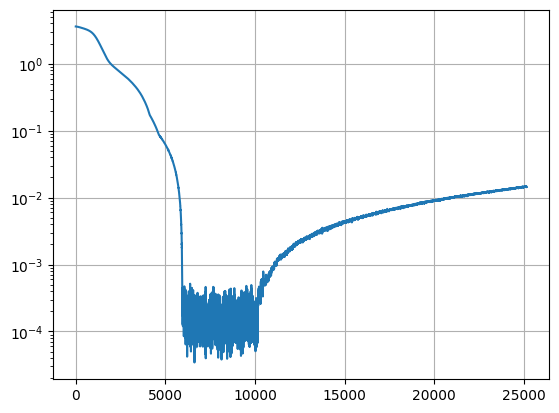

In [36]:
import numpy as np
import matplotlib.pyplot as plt
generator_losses = np.array(out_step_100["losses"]["generator"][1:])
plt.plot(generator_losses)
plt.yscale("log")
plt.grid(True)

In [57]:
generator_0= out_step_0["generator"]
log_lgs_0 = out_step_0["log_lgs"]

oracle_generator = torch.tensor([[0, -1], [1, 0]], dtype=torch.float32, requires_grad=False).unsqueeze(0)
scalar = oracle_generator/log_lgs_0
scalar

tensor([[[ 0.0000, -0.3755],
         [-0.3755,  0.0000]],

        [[ 0.0000,  0.4452],
         [ 0.4453, -0.0000]],

        [[ 0.0000,  0.7101],
         [ 0.7101,  0.0000]]])

In [65]:
torch.manual_seed(42)
generator_0=torch.randn(1, 2, 2, requires_grad=True)
w_0 = torch.randn(3, requires_grad=True)
optim_generator= torch.optim.Adam([generator_0, w_0], lr=0.00035)

N_epochs=100000

for _ in range(N_epochs):
    optim_generator.zero_grad()

    log_lgs_hat = torch.einsum("N,dmn->Nmn", w_0, generator_0)
    loss = torch.mean((log_lgs_hat - log_lgs_0) ** 2)

    loss.backward()
    optim_generator.step()
    print(f"Loss: {loss.item()}")

Loss: 2.375493288040161
Loss: 2.3746254444122314
Loss: 2.3737573623657227
Loss: 2.3728904724121094
Loss: 2.372023344039917
Loss: 2.3711564540863037
Loss: 2.3702898025512695
Loss: 2.3694238662719727
Loss: 2.3685576915740967
Loss: 2.367692232131958
Loss: 2.3668267726898193
Loss: 2.365962266921997
Loss: 2.3650972843170166
Loss: 2.3642330169677734
Loss: 2.3633689880371094
Loss: 2.3625056743621826
Loss: 2.3616421222686768
Loss: 2.360779285430908
Loss: 2.3599164485931396
Loss: 2.3590540885925293
Loss: 2.358191728591919
Loss: 2.357330322265625
Loss: 2.356468915939331
Loss: 2.355607748031616
Loss: 2.3547470569610596
Loss: 2.353886842727661
Loss: 2.3530266284942627
Loss: 2.3521666526794434
Loss: 2.3513071537017822
Loss: 2.3504483699798584
Loss: 2.3495893478393555
Loss: 2.3487303256988525
Loss: 2.347872495651245
Loss: 2.3470144271850586
Loss: 2.346156597137451
Loss: 2.345299482345581
Loss: 2.344442129135132
Loss: 2.34358549118042
Loss: 2.342728614807129
Loss: 2.3418726921081543
Loss: 2.341017007

KeyboardInterrupt: 

In [39]:
lgs_0 = torch.matrix_exp(out_step_0["log_lgs"])
lgs_100 = torch.matrix_exp(out_step_100["log_lgs"])
lgs_200 = torch.matrix_exp(out_step_200["log_lgs"])
# lgs_300 = torch.matrix_exp(out_step_300["log_lgs"])

print("lgs at step 0:\n", lgs_0)
print("lgs at step 100:\n", lgs_100)
print("lgs at step 200:\n", lgs_200)
# print("lgs at step 300:\n", lgs_300)

print("generator at step 0:\n", out_step_0["generator"])
print("generator at step 100:\n", out_step_100["generator"])
print("generator at step 200:\n", out_step_200["generator"])
# print("generator at step 300:\n", out_step_300["generator"])

lgs at step 0:
 tensor([[[-0.8877,  0.4606],
         [-0.4605, -0.8877]],

        [[-0.6250, -0.7806],
         [ 0.7806, -0.6250]],

        [[ 0.1619, -0.9868],
         [ 0.9868,  0.1619]]])
lgs at step 100:
 tensor([[[-0.8988,  0.4686],
         [-0.4718, -0.8946]],

        [[-0.6325, -0.7870],
         [ 0.7862, -0.6393]],

        [[ 0.1596, -0.9962],
         [ 0.9980,  0.1510]]])
lgs at step 200:
 tensor([[[-0.9152,  0.4788],
         [-0.4858, -0.9055]],

        [[-0.6431, -0.7968],
         [ 0.7946, -0.6588]],

        [[ 0.1569, -1.0098],
         [ 1.0131,  0.1368]]])
generator at step 0:
 tensor([[[-1.2900e-05,  9.7363e-01],
         [-9.7359e-01, -2.4495e-05]]])
generator at step 100:
 tensor([[[-8.8130e-03,  9.6548e-01],
         [-9.6519e-01, -4.7916e-04]]])
generator at step 200:
 tensor([[[-0.0215,  0.9947],
         [-0.9929, -0.0021]]])


In [4]:
her_geo_dis.generator

Parameter containing:
tensor([[[-6.0437e-06, -5.4854e-02],
         [ 5.4203e-02,  3.0285e-05]]], requires_grad=True)

In [5]:
her_geo_dis.lgs

tensor([[[-0.8919,  0.4562],
         [-0.4475, -0.8919]],

        [[-0.6130, -0.7982],
         [ 0.7808, -0.6126]],

        [[ 0.1772, -0.9955],
         [ 0.9743,  0.1775]]], grad_fn=<LinalgMatrixExpBackward0>)

In [6]:
for param in her_geo_dis.encoder.parameters():
    print(param.data)

tensor([[1.0099e+00, 2.3543e-04],
        [1.7655e-04, 9.8977e-01]])
tensor([-0.0041, -0.0023])


In [7]:
for param in her_geo_dis.decoder.parameters():
    print(param.data)

tensor([[ 9.8997e-01, -5.9011e-04],
        [-4.0776e-04,  1.0104e+00]])
tensor([0.0041, 0.0022])
